### Download and unzipglove embedding

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip -P /content/drive/MyDrive/Sem_4/glove_model/
!unzip /content/drive/MyDrive/Sem_4/glove_model/glove*.zip -d /content/drive/MyDrive/Sem_4/glove_model/

### Importing required liabraries

In [37]:
import json
import pandas as pd
import os
import spacy
import numpy as np
from tqdm import tqdm
import re
tqdm.pandas()
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import  preprocessing 
le= preprocessing.LabelEncoder()

import spacy
# !python -m spacy download en_core_web_sm
# !pip install pandarallel 
import en_core_web_sm
nlp = en_core_web_sm.load()

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define static variables

In [42]:
base_path= r"/content/drive/MyDrive/Sem_4"
train_data_path = "data/train.jsonl"
dev_data_path = "data/dev.jsonl"
test_data_path = "data/test.jsonl"

### Read the dataset and store in dataframe

In [43]:
def get_dataset_in_df(path, train=True):
  if train == True:
    with open(os.path.join(base_path, path), "r") as f:
        text  = []
        label = []
        id    = []
        for line in f:
            data = json.loads(line)
            text.append(data["text"])
            label.append(data["label"])
            id.append(data["id"])
    df = pd.DataFrame(columns=["text", "label", "id"])
    df["text"] = text
    df["label"] = label
    df["id"] = id
  else:
      with open(os.path.join(base_path, path), "r") as f:
          text  = []
          id    = []
          for line in f:
              data = json.loads(line)
              text.append(data["text"])
              id.append(data["id"])
      df = pd.DataFrame(columns=["text", "id"])
      df["text"] = text
      df["id"] = id
  return df

## Cleaning of dataset  
As we have to calculate label of corresponding text so we will clean the data using spacy. But before cleaning let's explore the data. 

In [41]:
# df["label"].value_counts()

As we can see we have some inbalnce categories as well so we will take care of them later.

In [11]:

# From the result I think name of person , place , organisation are not of use and we can't find in the word embedding ,
# Let's try to find some words which we can not find in word embedding.

# Some observation 
#  There are some words which i can not find in the embedding like my surname , So we will skip them.


In [44]:
# Let's read file, to understand word embedding
def get_embedding_dict(embedding_path):
    embedding_vectot_dict= {}
    with open(os.path.join(base_path, embedding_path),"r", encoding= "utf8") as f:
        for line in tqdm(f.readlines()):
            word, *vector = line.split()
            embedding_vectot_dict[word] = np.array(vector, "float32")
    return embedding_vectot_dict

In [13]:
# # We will use following steps for data cleaning
# # 1) lowercase
# # 2) cleaning data, by removing punctuation and spetial character.
# # 3) removing stopwards 
# # 4) lemmatization
# # It is not making sense to me kee PER and organization in the sentence , I tried to work on this, But unable to figure out what we can do with this

# # entities = ["PERSON"]
# import regex as re
# tqdm.pandas()
# # for i in range(1):
# def get_given_entities(sentence):
#     # sentence = df["text"][i]
#     sentence = re.sub("[^a-zA-Z ]+", "", sentence.lower())
#     doc = nlp(sentence)
#     entities = {}
#     for ent in doc.ents:
#         ent_label = ent.label_
#         ent_text = ent.text
#         if ent_label not in entities.keys():
#             entities[ent_label] = []
#             entities[ent_label].append(ent_text)
#         else:
#             entities[ent_label].append(ent_text)
#     return entities

# df["NER"] = df["text"].parallel_apply(lambda sentence: get_given_entities(sentence) )

In [45]:
def remove_punctuation(sentence):
    # sentence = df["text"][i]
    sentence = re.sub("[^a-zA-Z ]+", "", sentence.lower())    
    sentence= " ".join([word for word in sentence.split() if len(word)>1 and word not in stop_words])
    return sentence

In [46]:
def drop_if_length_less_than_2(df, column_name):
    for idx, sentence in tqdm(enumerate(df[column_name].to_list())):
        if len(sentence)<2:
            df.drop([idx], axis=0, inplace=True)

In [61]:
def get_prediction_tsv(df, pred, filename = filename):
    predictions_test = pd.DataFrame()
    predictions_test["Id"] = df["id"]
    predictions_test["label"] = le.inverse_transform(pred)
    predictions_test.to_csv(base_path +  filename, sep="\t", 
                        header = False, index = False)

In [47]:
# def get_vector(sentence):
def get_sentence_embedding(df, column_name, embedding_vectot_dict):
    words_not_in_dict=[]
    sentence_embedding = []
    for sentence in tqdm(df[column_name].to_list()):
        words= sentence.split(" ")
        array = []
        for word in words:
            try:
                word_array= embedding_vectot_dict[word]
                array.append(word_array)
            except:
                words_not_in_dict.append(word)
                pass
        sentence_embedding.append(list(np.mean(array, axis=0)))

    return sentence_embedding

In [48]:
stop_words = list(nlp.Defaults.stop_words)
embedding_path_50 = "glove_model/glove.6B.300d.txt"

print("Reading Dataset")
train_df = get_dataset_in_df(train_data_path, train=True)
dev_df = get_dataset_in_df(dev_data_path, train=True)
test_df = get_dataset_in_df(test_data_path, train= False)

Reading Dataset


In [49]:
print("Reading embedding")
embedding_dict_50 = get_embedding_dict(embedding_path_50)

print("Removed Punctuation")
train_df["removed_punctuation"] = train_df["text"].progress_apply(lambda sentence: remove_punctuation(sentence) )
dev_df["removed_punctuation"] = dev_df["text"].progress_apply(lambda sentence: remove_punctuation(sentence) )
test_df["removed_punctuation"] = test_df["text"].progress_apply(lambda sentence: remove_punctuation(sentence) )

drop_if_length_less_than_2(train_df, "removed_punctuation")
drop_if_length_less_than_2(dev_df, "removed_punctuation")

Reading embedding


100%|██████████| 400000/400000 [00:23<00:00, 17382.14it/s]


Removed Punctuation


100%|██████████| 6849/6849 [00:02<00:00, 2329.83it/s]
186282it [00:00, 502422.23it/s]
6844it [00:00, 519092.52it/s]


In [50]:
print("Creating sentence Embedding")
train_sentence_embedding = get_sentence_embedding(train_df, "removed_punctuation", embedding_dict_50)
dev_sentence_embedding = get_sentence_embedding(dev_df, "removed_punctuation", embedding_dict_50)
test_sentence_embedding = get_sentence_embedding(test_df, "removed_punctuation", embedding_dict_50)

Creating sentence Embedding


100%|██████████| 6849/6849 [00:00<00:00, 11220.76it/s]


In [51]:
train_df["sentence_embedding"]= train_sentence_embedding
dev_df["sentence_embedding"]= dev_sentence_embedding
test_df["sentence_embedding"]= test_sentence_embedding

In [52]:
len(test_sentence_embedding)

6849

In [53]:
print("Creating encoding")
le.fit(train_df["label"])
train_df["encoder"] = le.transform(train_df["label"])
dev_df["encoder"] = le.transform(dev_df["label"])
print("########################################################")
print("----- Enjoy Model Building Now-------")

Creating encoding
########################################################
----- Enjoy Model Building Now-------


In [54]:
x_train = tf.convert_to_tensor(train_df["sentence_embedding"].to_list(), "float32")
y_train = tf.convert_to_tensor(train_df['encoder'].to_numpy().reshape(-1,1), "float32")

x_test = tf.convert_to_tensor(dev_df["sentence_embedding"].to_list(), "float32")
y_test = tf.convert_to_tensor(dev_df['encoder'].to_numpy().reshape(-1,1), "float32")

test = tf.convert_to_tensor(test_df["sentence_embedding"].to_list(), "float32")

In [55]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape, test.shape

(TensorShape([186281, 300]),
 TensorShape([6844, 300]),
 TensorShape([186281, 1]),
 TensorShape([6844, 1]),
 TensorShape([6849, 300]))

In [56]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dev_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
BATCH_SIZE = 64
train_ds = train_ds.batch(BATCH_SIZE,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
dev_ds = dev_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

## Create Model

### Model 1

In [46]:
input = keras.Input(shape = (300,))

x = keras.layers.Dense(150, activation= "relu")(input)
x = keras.layers.Dense(150, activation= "relu")(x)
x = keras.layers.Dense(150, activation= "relu")(x)

x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(75, activation= "relu")(x)
x = keras.layers.Dense(75, activation= "relu")(x)
x = keras.layers.Dense(75, activation= "relu")(x)

x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(50, activation= "relu")(x)
x = keras.layers.Dense(50, activation= "relu")(x)
x = keras.layers.Dense(50, activation= "relu")(x)

output = keras.layers.Dense(15)(x)

model = keras.Model(input, output)

In [47]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_10 (Dense)            (None, 150)               45150     
                                                                 
 dense_11 (Dense)            (None, 150)               22650     
                                                                 
 dense_12 (Dense)            (None, 150)               22650     
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_13 (Dense)            (None, 75)                11325     
                                                                 
 dense_14 (Dense)            (None, 75)                5700

In [48]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer = keras.optimizers.Adam(learning_rate=0.0001),
             metrics = ['accuracy'])

In [49]:
history = model.fit(train_ds, epochs=18, batch_size = BATCH_SIZE, validation_data = dev_ds)

Epoch 1/18
2910/2910 [==============================] - 14s 3ms/step - loss: 1.1412 - accuracy: 0.6449 - val_loss: 1.0508 - val_accuracy: 0.6785
Epoch 2/18
2910/2910 [==============================] - 10s 3ms/step - loss: 0.8489 - accuracy: 0.7436 - val_loss: 0.9567 - val_accuracy: 0.7146
Epoch 3/18
2910/2910 [==============================] - 10s 3ms/step - loss: 0.7848 - accuracy: 0.7635 - val_loss: 0.9132 - val_accuracy: 0.7289
Epoch 4/18
2910/2910 [==============================] - 9s 3ms/step - loss: 0.7482 - accuracy: 0.7749 - val_loss: 0.8887 - val_accuracy: 0.7323
Epoch 5/18
2910/2910 [==============================] - 9s 3ms/step - loss: 0.7186 - accuracy: 0.7848 - val_loss: 0.8679 - val_accuracy: 0.7397
Epoch 6/18
2910/2910 [==============================] - 9s 3ms/step - loss: 0.6951 - accuracy: 0.7917 - val_loss: 0.8529 - val_accuracy: 0.7459
Epoch 7/18
2910/2910 [==============================] - 9s 3ms/step - loss: 0.6769 - accuracy: 0.7973 - val_loss: 0.8398 - val_accura

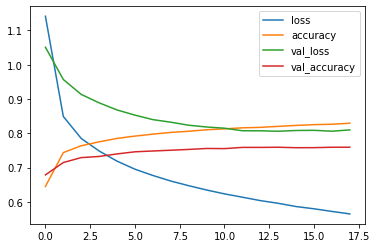

In [51]:
pd.DataFrame(history.history).plot()

In [53]:
filename = "/Code/predictions/predictions_test.tsv"

model.save(base_path+ "/Code/Model_Saving/model1")
model = keras.models.load_model(base_path+ "/Code/Model_Saving/model1")
pred = np.argmax(model.predict(test), axis=1)

get_prediction_tsv(test_df, pred, filename = filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Sem_4/Code/Model_Saving/model1/assets


### Model 2

In [57]:
input = keras.Input(shape = (300,))

x = keras.layers.Dense(150, activation= "relu")(input)
x = keras.layers.Dense(150, activation= "relu")(x)
x = keras.layers.Dense(150, activation= "relu")(x)

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(75, activation= "relu")(x)
x = keras.layers.Dense(75, activation= "relu")(x)
x = keras.layers.Dense(75, activation= "relu")(x)

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(50, activation= "relu")(x)
x = keras.layers.Dense(50, activation= "relu")(x)
x = keras.layers.Dense(50, activation= "relu")(x)


x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(25, activation= "relu")(x)
x = keras.layers.Dense(25, activation= "relu")(x)
x = keras.layers.Dense(25, activation= "relu")(x)
output = keras.layers.Dense(15)(x)

model_2 = keras.Model(input, output)

In [58]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_10 (Dense)            (None, 150)               45150     
                                                                 
 dense_11 (Dense)            (None, 150)               22650     
                                                                 
 dense_12 (Dense)            (None, 150)               22650     
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                           

In [59]:
model_2.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer = keras.optimizers.Adam(learning_rate=0.0001),
             metrics = ['accuracy'])

In [60]:
history = model_2.fit(train_ds, epochs=22, batch_size = BATCH_SIZE, validation_data = dev_ds)

Epoch 1/22
2910/2910 [==============================] - 17s 5ms/step - loss: 1.5161 - accuracy: 0.5304 - val_loss: 1.2690 - val_accuracy: 0.6135
Epoch 2/22
2910/2910 [==============================] - 13s 5ms/step - loss: 1.0353 - accuracy: 0.6953 - val_loss: 1.0846 - val_accuracy: 0.6756
Epoch 3/22
2910/2910 [==============================] - 13s 5ms/step - loss: 0.9243 - accuracy: 0.7308 - val_loss: 1.0118 - val_accuracy: 0.7087
Epoch 4/22
2910/2910 [==============================] - 15s 5ms/step - loss: 0.8630 - accuracy: 0.7504 - val_loss: 0.9661 - val_accuracy: 0.7207
Epoch 5/22
2910/2910 [==============================] - 18s 6ms/step - loss: 0.8234 - accuracy: 0.7616 - val_loss: 0.9382 - val_accuracy: 0.7274
Epoch 6/22
2910/2910 [==============================] - 16s 6ms/step - loss: 0.7915 - accuracy: 0.7710 - val_loss: 0.9242 - val_accuracy: 0.7347
Epoch 7/22
2910/2910 [==============================] - 19s 7ms/step - loss: 0.7659 - accuracy: 0.7787 - val_loss: 0.9063 - val_ac

In [62]:
filename = "/Code/predictions/predictions_test2.tsv"

model.save(base_path+ "/Code/Model_Saving/model2")
model = keras.models.load_model(base_path+ "/Code/Model_Saving/model2")
pred = np.argmax(model.predict(test), axis=1)

get_prediction_tsv(test_df, pred, filename = filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Sem_4/Code/Model_Saving/model2/assets


### Model 3

In [76]:
input = keras.Input(shape = (300,))

x = keras.layers.Dense(150, activation= "relu")(input)
x = keras.layers.Dense(150, activation= "relu")(x)
x = keras.layers.Dense(150, activation= "relu")(x)

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(75, activation= "relu")(x)
x = keras.layers.Dense(75, activation= "relu")(x)
x = keras.layers.Dense(75, activation= "relu")(x)

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(50, activation= "relu")(x)
x = keras.layers.Dense(50, activation= "relu")(x)
x = keras.layers.Dense(50, activation= "relu")(x)

output = keras.layers.Dense(15)(x)

model_3 = keras.Model(input, output)

In [77]:
model_3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_53 (Dense)            (None, 150)               45150     
                                                                 
 dense_54 (Dense)            (None, 150)               22650     
                                                                 
 dense_55 (Dense)            (None, 150)               22650     
                                                                 
 dropout_11 (Dropout)        (None, 150)               0         
                                                                 
 batch_normalization_11 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                           

In [78]:
model_3.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer = keras.optimizers.Adam(learning_rate=0.0001),
             metrics = ['accuracy'])

In [79]:
history = model_3.fit(train_ds, epochs=19, batch_size = BATCH_SIZE, validation_data = dev_ds)

Epoch 1/19
2910/2910 [==============================] - 13s 4ms/step - loss: 1.2420 - accuracy: 0.6293 - val_loss: 1.0245 - val_accuracy: 0.6994
Epoch 2/19
2910/2910 [==============================] - 12s 4ms/step - loss: 0.8537 - accuracy: 0.7458 - val_loss: 0.9255 - val_accuracy: 0.7273
Epoch 3/19
2910/2910 [==============================] - 11s 4ms/step - loss: 0.7828 - accuracy: 0.7662 - val_loss: 0.8848 - val_accuracy: 0.7366
Epoch 4/19
2910/2910 [==============================] - 11s 4ms/step - loss: 0.7399 - accuracy: 0.7791 - val_loss: 0.8607 - val_accuracy: 0.7415
Epoch 5/19
2910/2910 [==============================] - 11s 4ms/step - loss: 0.7119 - accuracy: 0.7869 - val_loss: 0.8397 - val_accuracy: 0.7534
Epoch 6/19
2910/2910 [==============================] - 11s 4ms/step - loss: 0.6895 - accuracy: 0.7939 - val_loss: 0.8338 - val_accuracy: 0.7552
Epoch 7/19
2910/2910 [==============================] - 11s 4ms/step - loss: 0.6723 - accuracy: 0.7979 - val_loss: 0.8178 - val_ac

In [80]:
filename = "/Code/predictions/predictions_test_final.tsv"

model_3.save(base_path+ "/Code/Model_Saving/model3")
model_3 = keras.models.load_model(base_path+ "/Code/Model_Saving/model3")
pred = np.argmax(model_3.predict(test), axis=1)
get_prediction_tsv(test_df, pred, filename = filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Sem_4/Code/Model_Saving/model3/assets


### Model 4

In [30]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 81.6 MB/s 


In [33]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
model.fit(x_train.numpy(),
          y_train.numpy(),
          verbose=True)

Learning rate set to 0.188538
0:	learn: 1.9840926	total: 121ms	remaining: 2m 1s
1:	learn: 1.7929868	total: 247ms	remaining: 2m 3s
2:	learn: 1.6602383	total: 334ms	remaining: 1m 50s
3:	learn: 1.5689462	total: 395ms	remaining: 1m 38s
4:	learn: 1.4986740	total: 454ms	remaining: 1m 30s
5:	learn: 1.4272400	total: 517ms	remaining: 1m 25s
6:	learn: 1.3690460	total: 585ms	remaining: 1m 22s
7:	learn: 1.3157909	total: 646ms	remaining: 1m 20s
8:	learn: 1.2698387	total: 707ms	remaining: 1m 17s
9:	learn: 1.2316308	total: 769ms	remaining: 1m 16s
10:	learn: 1.2011686	total: 832ms	remaining: 1m 14s
11:	learn: 1.1750192	total: 892ms	remaining: 1m 13s
12:	learn: 1.1495921	total: 953ms	remaining: 1m 12s
13:	learn: 1.1258877	total: 1.01s	remaining: 1m 11s
14:	learn: 1.1023180	total: 1.08s	remaining: 1m 10s
15:	learn: 1.0820938	total: 1.15s	remaining: 1m 10s
16:	learn: 1.0635549	total: 1.21s	remaining: 1m 9s
17:	learn: 1.0457636	total: 1.28s	remaining: 1m 9s
18:	learn: 1.0311795	total: 1.35s	remaining: 1m 

In [36]:
pred = model.predict(x_test.numpy())
np.mean((pred == y_test.numpy()).flatten())

### Model 5

In [66]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=2000,
                           task_type="GPU",
                           devices='0:1')
model.fit(x_train.numpy(),
          y_train.numpy(),
          verbose=True)

pred = model.predict(x_test.numpy())
print("accuracy is ", np.mean((pred == y_test.numpy()).flatten()))

Learning rate set to 0.105838
0:	learn: 2.2579468	total: 123ms	remaining: 4m 5s
1:	learn: 2.0751756	total: 246ms	remaining: 4m 6s
2:	learn: 1.9459900	total: 327ms	remaining: 3m 37s
3:	learn: 1.8377312	total: 389ms	remaining: 3m 13s
4:	learn: 1.7447125	total: 452ms	remaining: 3m
5:	learn: 1.6720282	total: 514ms	remaining: 2m 50s
6:	learn: 1.6128094	total: 580ms	remaining: 2m 45s
7:	learn: 1.5596917	total: 633ms	remaining: 2m 37s
8:	learn: 1.5125992	total: 696ms	remaining: 2m 33s
9:	learn: 1.4707544	total: 753ms	remaining: 2m 29s
10:	learn: 1.4360801	total: 810ms	remaining: 2m 26s
11:	learn: 1.4006697	total: 872ms	remaining: 2m 24s
12:	learn: 1.3710660	total: 931ms	remaining: 2m 22s
13:	learn: 1.3408229	total: 989ms	remaining: 2m 20s
14:	learn: 1.3132638	total: 1.05s	remaining: 2m 19s
15:	learn: 1.2900070	total: 1.11s	remaining: 2m 18s
16:	learn: 1.2656601	total: 1.18s	remaining: 2m 17s
17:	learn: 1.2423645	total: 1.24s	remaining: 2m 17s
18:	learn: 1.2226831	total: 1.3s	remaining: 2m 16s

In [48]:
pred = model.predict(x_test.numpy())
np.mean((pred == y_test.numpy()).flatten())

0.6177673874926943

References  
1) Spacy for cleaning dataset   
2) Gensim official documentation.  
3) [Reading glove vector](#https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/)  
4) [Word2vec , Fasttext with genism](#https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c)  
5) [spacytoken documentation for cleaning data](#https://spacy.io/api/token)  
6) [Catboost](#https://catboost.ai/en/docs/concepts/python-usages-examples#load-from-file)